In [5]:
!pip install -q pytorch_lightning
!pip install -q torchmetrics
!pip install icrawler

  Using cached https://files.pythonhosted.org/packages/b4/b2/c58ff189f662fb5807a921a590a55bad3ce29bd42252135916711ee00a59/icrawler-0.6.4.tar.gz
  Created wheel for icrawler: filename=icrawler-0.6.4-py2.py3-none-any.whl size=35063 sha256=a12bee21fb2d0e26ad5197160563c8b0fe0f109184992ac7c65bcd426f35626e
  Stored in directory: /root/.cache/pip/wheels/57/f7/08/e89027083863374b83f7b3e3ce52a9afa1674424a379c7faf9
Successfully built icrawler


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
import torchsummary
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger
from PIL import Image
from PIL import ImageFile

In [7]:
# ダウンロード後の処理について定義
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# 画像のダウンロード
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
# PILは、大きなサイズのデータをデフォルトで見過ごす仕様になっているので、True(見過ごさない)設定にする。
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ホッキョクグマ
# storage : 保存場所及びディレクトリの指定。パスを指定すれば任意の場所に画像を格納可能
# google_crawler1 = GoogleImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/polar_bear'})
# google_crawler1.crawl(keyword='ホッキョクグマ', max_num=120)
# bing_crawler1 = BingImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/polar_bear'})
# bing_crawler1.crawl(keyword='ホッキョクグマ', filters=None, max_num=130)
# ライオン
# google_crawler2 = GoogleImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/lion'})
# google_crawler2.crawl(keyword='ライオン', max_num=130)
# bing_crawler2 = BingImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/lion'})
# bing_crawler2.crawl(keyword='ライオン', filters=None, max_num=130)
# シマウマ
# google_crawler3 = GoogleImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/zebra'})
# google_crawler3.crawl(keyword='シマウマ', max_num=120)
# bing_crawler3 = BingImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/zebra'})
# bing_crawler3.crawl(keyword='シマウマ', filters=None, max_num=130)
# ゾウ
# google_crawler4 = GoogleImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/elephant'})
# google_crawler4.crawl(keyword='ゾウ', max_num=130)
# bing_crawler4 = BingImageCrawler(parser_threads=4, storage={'root_dir': '/content/animal/train/elephant'})
# bing_crawler4.crawl(keyword='ゾウ', filters=None, max_num=130)

2021-06-16 03:32:56,660 - INFO - icrawler.crawler - start crawling...
2021-06-16 03:32:56,661 - INFO - icrawler.crawler - starting 1 feeder threads...
2021-06-16 03:32:56,667 - INFO - feeder - thread feeder-001 exit
2021-06-16 03:32:56,674 - INFO - icrawler.crawler - starting 4 parser threads...
2021-06-16 03:32:56,680 - INFO - icrawler.crawler - starting 1 downloader threads...
2021-06-16 03:32:57,361 - INFO - parser - parsing result page https://www.google.com/search?q=%E3%83%A9%E3%82%A4%E3%82%AA%E3%83%B3&ijn=1&start=100&tbs=&tbm=isch
2021-06-16 03:32:57,410 - INFO - downloader - skip downloading file 000001.jpg
2021-06-16 03:32:57,415 - INFO - downloader - skip downloading file 000002.jpg
2021-06-16 03:32:57,420 - INFO - downloader - skip downloading file 000003.jpg
2021-06-16 03:32:57,423 - INFO - downloader - skip downloading file 000004.jpg
2021-06-16 03:32:57,427 - INFO - downloader - skip downloading file 000005.jpg
2021-06-16 03:32:57,433 - INFO - downloader - skip downloading

In [11]:
# ライオンの画像を表示
from IPython.display import Image,display_jpeg
display_jpeg(Image("/content/animal/train/elephant/000001.jpg"))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 隠しファイルの.ipynb_checkpointsがある場合は、.class_to_idxする際に"0"として出力されるので、以下コードで削除する。
# !rm -rf animal/.ipynb_checkpoints

In [12]:
dataset = datasets.ImageFolder('/content/animal/train/', transform)

In [13]:
dataset

Dataset ImageFolder
    Number of datapoints: 458
    Root location: /content/animal/train/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

前処理後の画像を確認する為に、(縦, 横, チャネル数)に変換する。

In [14]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [15]:
dataset_sample = np.transpose(dataset[0][0], (1, 2, 0))

In [16]:
dataset_sample.shape

torch.Size([224, 224, 3])

2021-06-16 03:34:22,135 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


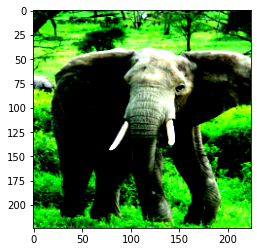

In [17]:
plt.imshow(dataset_sample)

In [18]:
# クラスの確認
dataset.class_to_idx

{'elephant': 0, 'lion': 1, 'polar_bear': 2, 'zebra': 3}

In [19]:
# データの分割
train_val = dataset

# 分割割合
n_train = 360
n_val = 98

# シードの固定
pl.seed_everything(0)

# データの分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

# バッチサイズ
batch_size = 10

# DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)

Global seed set to 0


In [20]:
# ファインチューニング
from torchvision.models import resnet18

In [21]:
# ネットワークの構築
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.feature = resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 4)

    def forward(self, x):
        h = self.feature(x)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    # def test_step(self, batch, batch_idx):
    #     x, t = batch
    #     y = self(x)
    #     loss = F.cross_entropy(y, t)
    #     self.log('test_loss', loss, on_step=False, on_epoch=True)
    #     self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
    #     return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

In [22]:
# 学習
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=5, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type   | Params
-----------------------------------
0 | feature | ResNet | 11.7 M
1 | fc      | Linear | 4.0 K 
-----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.774    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Global seed set to 0


In [23]:
# 学習結果
trainer.callback_metrics

{'train_acc': tensor(1., device='cuda:0'),
 'train_acc_epoch': tensor(0.9694, device='cuda:0'),
 'train_acc_step': tensor(1., device='cuda:0'),
 'train_loss': tensor(0.0039, device='cuda:0'),
 'train_loss_epoch': tensor(0.1017, device='cuda:0'),
 'train_loss_step': tensor(0.0039, device='cuda:0'),
 'val_acc': tensor(0.9898, device='cuda:0'),
 'val_loss': tensor(0.0092, device='cuda:0')}

In [24]:
# 学習したモデルの保存
weight = net.state_dict()
torch.save(weight, 'animal.pt')

In [25]:
# ネットワークの構築
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.feature = resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 4)

    def forward(self, x):
        h = self.feature(x)
        h = self.fc(h)
        return h

In [26]:
# インスタンス化
net = Net().eval()

In [27]:
# 重みの読み込み
net.load_state_dict(torch.load('animal.pt'))

<All keys matched successfully>

In [35]:
# テスト画像
test_img = transform(Image.open('/content/animal/test/test3.jpg'))

In [36]:
test_img

tensor([[[ 0.9988,  1.0844,  1.0673,  ...,  0.0056,  0.2796,  0.5364],
         [ 0.9817,  1.0502,  1.0159,  ..., -0.0629,  0.1939,  0.4679],
         [ 0.9646,  0.9988,  0.9474,  ..., -0.0801,  0.1254,  0.3823],
         ...,
         [ 0.3994, -0.1486, -0.4397,  ...,  1.1529,  1.2043,  1.2214],
         [ 0.9132,  0.3309, -0.3198,  ...,  1.0844,  1.1700,  1.2043],
         [ 0.1083,  0.2282,  0.1426,  ...,  1.0331,  1.1358,  1.1872]],

        [[ 0.9055,  0.9930,  0.9755,  ..., -0.0574,  0.2052,  0.4678],
         [ 0.8880,  0.9580,  0.9230,  ..., -0.1099,  0.1352,  0.3978],
         [ 0.8704,  0.9055,  0.8529,  ..., -0.1099,  0.0826,  0.3277],
         ...,
         [ 0.3803, -0.1975, -0.4951,  ...,  1.1856,  1.2206,  1.2206],
         [ 0.9055,  0.2927, -0.3725,  ...,  1.1155,  1.1856,  1.2031],
         [ 0.0826,  0.1877,  0.1001,  ...,  1.0805,  1.1506,  1.1856]],

        [[ 0.8971,  0.9842,  0.9668,  ..., -0.0441,  0.0605,  0.2348],
         [ 0.8797,  0.9494,  0.9145,  ..., -0

In [37]:
test_img = test_img.unsqueeze(0)
test_img

tensor([[[[ 0.9988,  1.0844,  1.0673,  ...,  0.0056,  0.2796,  0.5364],
          [ 0.9817,  1.0502,  1.0159,  ..., -0.0629,  0.1939,  0.4679],
          [ 0.9646,  0.9988,  0.9474,  ..., -0.0801,  0.1254,  0.3823],
          ...,
          [ 0.3994, -0.1486, -0.4397,  ...,  1.1529,  1.2043,  1.2214],
          [ 0.9132,  0.3309, -0.3198,  ...,  1.0844,  1.1700,  1.2043],
          [ 0.1083,  0.2282,  0.1426,  ...,  1.0331,  1.1358,  1.1872]],

         [[ 0.9055,  0.9930,  0.9755,  ..., -0.0574,  0.2052,  0.4678],
          [ 0.8880,  0.9580,  0.9230,  ..., -0.1099,  0.1352,  0.3978],
          [ 0.8704,  0.9055,  0.8529,  ..., -0.1099,  0.0826,  0.3277],
          ...,
          [ 0.3803, -0.1975, -0.4951,  ...,  1.1856,  1.2206,  1.2206],
          [ 0.9055,  0.2927, -0.3725,  ...,  1.1155,  1.1856,  1.2031],
          [ 0.0826,  0.1877,  0.1001,  ...,  1.0805,  1.1506,  1.1856]],

         [[ 0.8971,  0.9842,  0.9668,  ..., -0.0441,  0.0605,  0.2348],
          [ 0.8797,  0.9494,  

In [87]:
with torch.no_grad():
    y = net(test_img)
    y_proba = y.softmax(dim=-1)
    y = torch.argmax(y, dim=1)

print('確率:', np.array(y_proba.max()*100))
print('どの動物か:', np.array(y[0]))

確率: 99.999916
どの動物か: 1


それぞれの中身の大小を比較して、その結果に応じて分類すると同時に、その動物である確率を取得する。

In [86]:
key = [k for k, v in dataset.class_to_idx.items() if v == y][0]
print(key)

lion
